# ttbar Analysis - Jet-Parton Assignment Training

This is the training notebook for the jet-parton assignment task. The goal is to associate the leading four jets in each event to their associated parent particles. We are trying to assign jets according to the labels in the diagram below:

<img src="utils/ttbar_labels.png" alt="ttbar_labels" width="500"/>


<mark>top<sub>lepton</sub></mark> and <mark>top<sub>hadron</sub></mark> jets do not necessarily correspond to top/antitop, respectively. The <mark>top<sub>lepton</sub></mark> jet is defined as having a lepton/neutrino pair as cousins, where the <mark>top<sub>hadron</sub></mark> jet is defined as having two jets as cousins. The <mark>W</mark> jets are not distinguished from each other.

The strategy for solving this problem is to train a boosted decision tree to find the correct assignments for each jet. Since we consider four jets per event with three unique labels (<mark>W</mark>, <mark>top<sub>lepton</sub></mark>, and <mark>top<sub>hadron</sub></mark>), there are twelve possible combinations of assignments:

<img src="utils/jetcombinations.png" alt="jetcombinations" width="700"/>

The combination with the highest BDT score will be selected for each event.
____

The workflow for this training notebook is outlined as follows:
* Load data and calculate training features and labels using `coffea`/`dask`
* Optimize BDT using $n$-fold cross-validation and track using `mlflow`
* Register best model in `mlflow` model repository

In [1]:
import awkward as ak
import cloudpickle
from coffea.nanoevents import NanoAODSchema
from coffea import processor
import datetime
import hist
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import utils

# ML-related imports
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import ParameterSampler
from xgboost import XGBClassifier

In [2]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster, want to use larger number for training)
N_FILES_MAX_PER_SAMPLE = 1

# set to True for DaskExecutor
USE_DASK_PROCESSING = True


### MACHINE LEARNING OPTIONS

# enable Dask (whether to use dask for hyperparameter optimization)
USE_DASK_ML = True

# enable MLFlow logging (to store metrics and models of hyperparameter optimization trials)
# if using MLFlow, be sure to add credentials in config_training.py before running code
USE_MLFLOW = True

# enable MLFlow model logging/registering
MODEL_LOGGING = True
MODEL_REGISTERING = False

# number of events to use for training (more results in higher efficiency, but slower to train)
N_EVENTS_TRAIN = 20000

### Defining a `coffea` Processor

The processor returns the training features and labels we will use in our BDT

In [3]:
# function to create column accumulator from list
def col_accumulator(a):
    return processor.column_accumulator(np.array(a))

processor_base = processor.ProcessorABC
class JetClassifier(processor_base):
    def __init__(self):
        super().__init__()
    
    def process(self, events):
                
        # filter electrons, muons, and jets
        selected_electrons = events.Electron[(events.Electron.pt > 30) & (np.abs(events.Electron.eta)<2.1) & 
                                             (events.Electron.cutBased==4) & (events.Electron.sip3d < 4)]
        selected_muons = events.Muon[(events.Muon.pt > 30) & (np.abs(events.Muon.eta)<2.1) & (events.Muon.tightId) & 
                                     (events.Muon.sip3d < 4) & (events.Muon.pfRelIso04_all < 0.15)]
        jet_filter = (events.Jet.pt > 30) & (np.abs(events.Jet.eta) < 2.4) & (events.Jet.isTightLeptonVeto)
        selected_jets = events.Jet[jet_filter]
        selected_genpart = events.GenPart
        even = (events.event%2==0)
            
        # single lepton requirement
        event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
        # require at least 4 jets
        event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
        # require at least one jet above B_TAG_THRESHOLD
        B_TAG_THRESHOLD = 0.5
        event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)
            
        # apply event filters
        selected_electrons = selected_electrons[event_filters]
        selected_muons = selected_muons[event_filters]
        selected_jets = selected_jets[event_filters]
        selected_genpart = selected_genpart[event_filters]
        even = even[event_filters]
            
        ### only consider 4j2b (signal) region
        region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2 # at least two b-tagged jets
        selected_jets_region = selected_jets[region_filter][:,:4] # only keep top 4 jets
        selected_electrons_region = selected_electrons[region_filter]
        selected_muons_region = selected_muons[region_filter]
        selected_genpart_region = selected_genpart[region_filter]
        even = even[region_filter]
            
        # filter events and calculate labels
        jets, electrons, muons, labels, even = utils.ml.training_filter(selected_jets_region, 
                                                                        selected_electrons_region, 
                                                                        selected_muons_region, 
                                                                        selected_genpart_region,
                                                                        even)
            
            
        # calculate mbjj
        # reconstruct hadronic top as bjj system with largest pT
        # the jet energy scale / resolution effect is not propagated to this observable at the moment
        trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
        trijet_labels = ak.combinations(labels, 3, fields=["j1", "j2", "j3"])
        trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
        trijet["label"] = trijet_labels.j1 + trijet_labels.j2 + trijet_labels.j3
        trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
        trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
        # pick trijet candidate with largest pT and calculate mass of system
        trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
        trijet_label = trijet["label"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)]
        observable = ak.flatten(trijet_mass)
        trijet_label = ak.flatten(trijet_label)
            
        # calculate features and labels
        features, labels, which_combination = utils.ml.get_training_set(jets, electrons, muons, labels)
    
            
        output = {"nevents": {events.metadata["dataset"]: len(events)},
                  "features": col_accumulator(features.tolist()),
                  "labels": col_accumulator(labels.tolist()),
                  "observable": col_accumulator(observable.tolist()),
                  "even": col_accumulator(even.tolist()),
                  "trijet_label": col_accumulator(trijet_label.tolist()),}
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [4]:
fileset = utils.file_input.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False)

# get rid of everything except ttbar__nominal for training purposes
fileset = {"ttbar__nominal": fileset["ttbar__nominal"]}

### Execute the data delivery pipeline

In [5]:
NanoAODSchema.warn_missing_crossrefs = False

if USE_DASK_PROCESSING:
    cloudpickle.register_pickle_by_value(utils)
    executor = processor.DaskExecutor(client=utils.clients.get_client(utils.config_training["global"]["AF"]))
else:
    executor = processor.FuturesExecutor(workers=utils.config_training["benchmarking"]["NUM_CORES"])
    
run = processor.Runner(executor=executor, schema=NanoAODSchema, savemetrics=True, metadata_cache={}, 
                       chunksize=utils.config_training["benchmarking"]["CHUNKSIZE"])

# preprocess
filemeta = run.preprocess(fileset, treename="Events")

# process
output, metrics = run(fileset, 
                      "Events", 
                      processor_instance = JetClassifier())

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [6]:
# grab features and labels and convert to np array
features = output['features'].value
labels = output['labels'].value
even = output['even'].value
observable = output['observable'].value

labels = labels.reshape((len(labels),))
even = np.repeat(even, 12) # twelve permutations for each event

The key for the labeling scheme is as follows

* 1: all jet assignments are correct
* -1: some jet assignments are correct (one or two are correct, others are incorrect)
* 0: all jet assignments are incorrect

There are twelve combinations for each event, so each event will have 1 correct combination, 2 completely incorrect combinations, and 9 partially correct combinations.

# Histograms of Training Variables
To vizualize the separation power of the different variables, histograms are created for each of the three labels. Only `all_correct` and `none_correct` are used for training purposes.

In [7]:
# separate by label for plotting
all_correct = features[labels==1,:]
some_correct = features[labels==-1,:]
none_correct = features[labels==0,:]

/opt/conda/lib/python3.8/site-packages/mplhep/utils.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/opt/conda/lib/python3.8/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/opt/conda/lib/python3.8/site-packages/mplhep/utils.py:245: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All

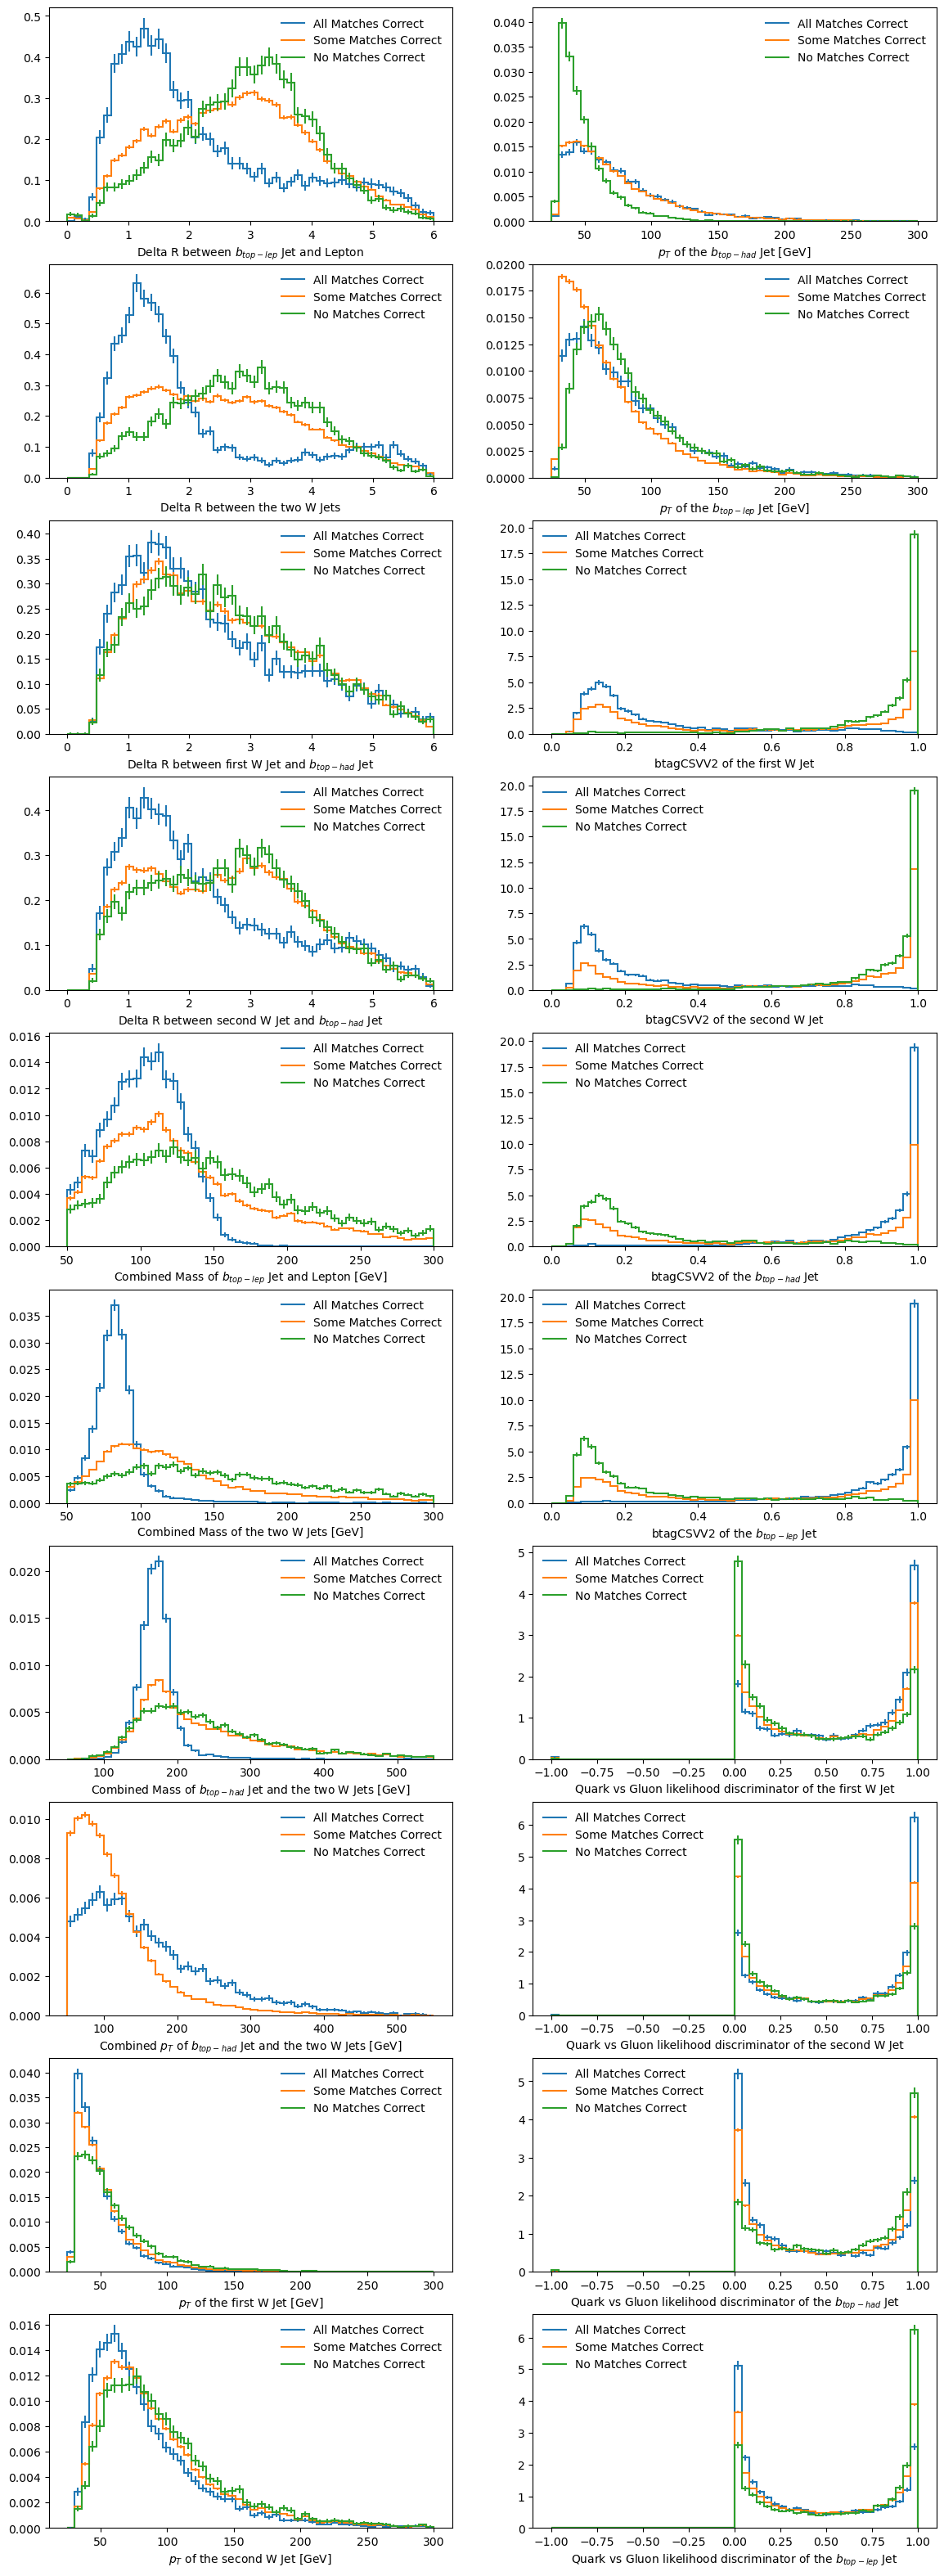

In [8]:
# make plots
utils.plotting.plot_training_variables(all_correct, some_correct, none_correct)

# Model Optimization

The model used here is `xgboost`'s gradient-boosted decision tree (`XGBClassifier`). Hyperparameter optimization is performed using random selection from a sample space of hyperparameters then testing model fits in a parallelized manner using `dask`. Optional `mlflow` logging is included.

In [9]:
# grab features and labels and convert to np array
features = output['features'].value
labels = output['labels'].value
labels[labels==-1]=0 # partially correct = wrong
even = output['even'].value # train different models for different events so that we utilize all events during inference

features = features.reshape((int(features.shape[0]/12),12,20))
labels = labels.reshape((int(labels.shape[0]/12),12))

shuffle_indices = np.array(range(features.shape[0])).astype(int)
np.random.shuffle(shuffle_indices)

# shuffle training data
features = features[shuffle_indices]
labels = labels[shuffle_indices]
which_combination = np.argmax(labels,axis=-1)
even = even[shuffle_indices]

features_even = features[even]
features_even = features_even.reshape((int(12*features_even.shape[0]),20))
labels_even = labels[even]
labels_even = labels_even.reshape((int(12*labels_even.shape[0]),))
which_combination_even = which_combination[even]

features_odd = features[np.invert(even)]
features_odd = features_odd.reshape((int(12*features_odd.shape[0]),20))
labels_odd = labels[np.invert(even)]
labels_odd = labels_odd.reshape((int(12*labels_odd.shape[0]),))
which_combination_odd = which_combination[np.invert(even)]

print("features_even.shape = ", features_even.shape)
print("features_odd.shape = ", features_odd.shape)

# calculate the number of events to train on (either the pre-set value or the total number)
N_EVENTS_TRAIN = min(min(int(features_odd.shape[0]/12), N_EVENTS_TRAIN), int(features_even.shape[0]/12))

print("N_EVENTS_TRAIN = ", N_EVENTS_TRAIN)

features_even.shape =  (38892, 20)
features_odd.shape =  (38052, 20)
N_EVENTS_TRAIN =  3171


In [10]:
# set up trials
if USE_MLFLOW:
    
    os.environ['MLFLOW_TRACKING_TOKEN'] = utils.config_training["ml"]["MLFLOW_TRACKING_TOKEN"]
    os.environ['MLFLOW_TRACKING_URI'] = utils.config_training["ml"]["MLFLOW_TRACKING_URI"]
    
    mlflow.set_tracking_uri(utils.config_training["ml"]["MLFLOW_TRACKING_URI"]) 
    mlflow.set_experiment(utils.config_training["ml"]["MLFLOW_EXPERIMENT_NAME"]) # this will create the experiment if it does not yet exist

    # grab experiment
    current_experiment=dict(mlflow.get_experiment_by_name(utils.config_training["ml"]["MLFLOW_EXPERIMENT_NAME"]))
    experiment_id=current_experiment['experiment_id']
    print("experiment_id = ", experiment_id)

    # create runs ahead of time (avoids conflicts when parallelizing mlflow logging)
    run_id_list=[]
    for n in range(utils.config_training["ml"]["N_TRIALS"]*2):
        run = MlflowClient().create_run(experiment_id=experiment_id, run_name=f"run-{n}")
        run_id_list.append(run.info.run_id)

experiment_id =  2


In [11]:
# get random sample of hyperparameters
sampler = ParameterSampler({'max_depth': np.arange(1,81,10,dtype=int), 
                            'n_estimators': np.arange(1,501,50,dtype=int), 
                            'learning_rate': np.linspace(0.01, 1, 10),
                            'min_child_weight': np.logspace(-1, 3, 20), 
                            'reg_lambda': [0, 0.25, 0.5, 0.75, 1], 
                            'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
                            'gamma': np.logspace(-4, 1, 20),
                            'tree_method': ["hist"],}, 
                            n_iter = utils.config_training["ml"]["N_TRIALS"], 
                            random_state=2) 

samples_even = list(sampler)
samples_odd = list(sampler)

# add additional info to each trial (and separate based on even/odd trained models)
for i in range(utils.config_training["ml"]["N_TRIALS"]):
    samples_even[i]['trial_num'] = i
    samples_even[i]['parity'] = 'even' # categorizes this trial as for even event numbers
    
    samples_odd[i]['trial_num'] = i
    samples_odd[i]['parity'] = 'odd' # categorizes this trial as for odd event numbers
    
    if USE_MLFLOW: 
        samples_even[i]['run_id'] = run_id_list[i]
        samples_odd[i]['run_id'] = run_id_list[i+utils.config_training["ml"]["N_TRIALS"]]
    
print("Example of Trial Parameters: ")
samples_even[0]

Example of Trial Parameters: 


{'tree_method': 'hist',
 'reg_lambda': 1,
 'reg_alpha': 0.5,
 'n_estimators': 1,
 'min_child_weight': 379.2690190732246,
 'max_depth': 1,
 'learning_rate': 0.89,
 'gamma': 0.0011288378916846883,
 'trial_num': 0,
 'parity': 'even',
 'run_id': '48871391497748e4b03f67b4fbacfffb'}

In [12]:
# evaluation matrix is used to calculate the fraction of matches correct within an event
_, _, evaluation_matrices = utils.ml.get_permutations_dict(4, 
                                                        include_labels=True, 
                                                        include_eval_mat=True)
evaluation_matrix = evaluation_matrices[4]

In [13]:
def modified_cross_validation(model, 
                              features, labels, 
                              evaluation_matrix, n_folds=2):
            
    # reshape features into per-event structure
    features = features.reshape((int(features.shape[0]/12),12,20))
    labels = labels.reshape((int(labels.shape[0]/12),12))
    which_combination = np.argmax(labels, axis=-1)
        
    # create random split for fold
    shuffle_ind = np.array(range(features.shape[0])).astype(int)
    np.random.shuffle(shuffle_ind)
    splits = np.array_split(shuffle_ind, n_folds)
    
    # initialize score arrays
    test_accuracy = np.zeros(n_folds)
    test_precision = np.zeros(n_folds)
    test_recall = np.zeros(n_folds)
    test_f1 = np.zeros(n_folds)
    test_roc_auc = np.zeros(n_folds)
    test_jet_score = np.zeros(n_folds)
    
    train_accuracy = np.zeros(n_folds)
    train_precision = np.zeros(n_folds)
    train_recall = np.zeros(n_folds)
    train_f1 = np.zeros(n_folds)
    train_roc_auc = np.zeros(n_folds)
    train_jet_score = np.zeros(n_folds)
    
    # iterate through folds
    for n in range(n_folds):
        
        # get current test features
        features_test = features[splits[n]]
        features_test = features_test.reshape((12*features_test.shape[0],20))
        labels_test = labels[splits[n]]
        labels_test = labels_test.reshape((12*labels_test.shape[0],))
        which_combination_test = which_combination[splits[n]]
        
        # get current train features
        train_ind = np.concatenate([splits[i] for i in range(n_folds) if not i==n])
        features_train = features[train_ind]
        features_train = features_train.reshape((12*features_train.shape[0],20))
        labels_train = labels[train_ind]
        labels_train = labels_train.reshape((12*labels_train.shape[0],))
        which_combination_train = which_combination[train_ind]
                
        # train model on training data
        model.fit(features_train, labels_train)
        
        # calculate predictions on both test and train data
        test_predictions = model.predict(features_test)
        train_predictions = model.predict(features_train)
        
        # calculate scores and fill arrays
        test_accuracy[n] = accuracy_score(labels_test, test_predictions)
        test_precision[n] = precision_score(labels_test, test_predictions)
        test_recall[n] = recall_score(labels_test, test_predictions)
        test_f1[n] = f1_score(labels_test, test_predictions)
        test_roc_auc[n] = roc_auc_score(labels_test, test_predictions)
        
        train_accuracy[n] = accuracy_score(labels_train, train_predictions)
        train_precision[n] = precision_score(labels_train, train_predictions)
        train_recall[n] = recall_score(labels_train, train_predictions)
        train_f1[n] = f1_score(labels_train, train_predictions)
        train_roc_auc[n] = roc_auc_score(labels_train, train_predictions)
        
        # calculate jet score (fraction of jets correct per event)
        test_predictions_prob = model.predict_proba(features_test)[:,1]
        train_predictions_prob = model.predict_proba(features_train)[:,1]
        test_predictions_prob = test_predictions_prob.reshape((int(test_predictions_prob.shape[0]/12),12))
        train_predictions_prob = train_predictions_prob.reshape((int(train_predictions_prob.shape[0]/12),12))
        
        train_predicted_combination = np.argmax(train_predictions_prob,axis=1)
        scores = np.zeros(len(which_combination_train))
        zipped = list(zip(which_combination_train.tolist(), train_predicted_combination.tolist()))
        for i in range(len(which_combination_train)):
            scores[i] = evaluation_matrix[zipped[i]]
        train_jet_score[n] = sum(scores)/len(scores)
        
        test_predicted_combination = np.argmax(test_predictions_prob,axis=1)
        scores = np.zeros(len(which_combination_test))
        zipped = list(zip(which_combination_test.tolist(), test_predicted_combination.tolist()))
        for i in range(len(which_combination_test)):
            scores[i] = evaluation_matrix[zipped[i]]
        test_jet_score[n] = sum(scores)/len(scores)
        
    
    return {"test_accuracy": test_accuracy, 
            "test_precision": test_precision, 
            "test_recall": test_recall,
            "test_f1": test_f1,
            "test_roc_auc": test_roc_auc,
            "test_jet_score": test_jet_score,
            "train_accuracy": train_accuracy, 
            "train_precision": train_precision, 
            "train_recall": train_recall,
            "train_f1": train_f1,
            "train_roc_auc": train_roc_auc, 
            "train_jet_score": train_jet_score,
            "model": model
           }

In [14]:
# the below function runs the above n-fold cross-validation and logs results
def fit_model(params, 
              features, 
              labels, 
              evaluation_matrix,
              n_folds,
              mlflowclient=None,
              use_mlflow=False,
              log_models=False,
              verbose=False): 
            
    # set up mlflow
    if use_mlflow:
        
        run_id = params["run_id"]
        
        if verbose: 
            print("run_id = ", run_id)
        
        for param_name, value in params.items():
            mlflowclient.log_param(run_id, param_name, value)
            
            if verbose: 
                print(f"logged param: {param_name} = {value}")
            
    # remove parameters that are not used for XGBClassifier
    params_copy = params.copy()
    params_copy.pop("trial_num")
    params_copy.pop("parity")
    if use_mlflow: 
        params_copy.pop("run_id")
    
    # initialize model with current trial paramters
    model = XGBClassifier(random_state=5, 
                          nthread=-1, # train on max. possible number of threads
                          **params_copy) 

    # perform n-fold cross-validation
    result = modified_cross_validation(model, features, labels,
                                      evaluation_matrix, n_folds=n_folds)
    
    # log results in mlflow
    if use_mlflow:
        for metric, value in result.items():
            if not metric=="model":
                mlflowclient.log_metric(run_id, metric, np.average(value))
                if verbose: 
                    print(f"logged metric: {metric} = {np.average(value)}")

        # manually end run
        mlflowclient.set_terminated(run_id)
        
        if log_models:
            signature = infer_signature(features, result["model"].predict(features))
            with mlflow.start_run(run_id=run_id, nested=True):
                mlflow.xgboost.log_model(result["model"], "model", signature=signature)
            result.pop("model")
                
    # return models if we don't save them in mlflow
    if not log_models:
        return {"score": np.average(result["test_jet_score"]),
                "full_result": result}
    
    return {"score": np.average(result["test_jet_score"])}

In [15]:
# function to provide necessary environment variables to workers
def initialize_mlflow(): 
    
    os.environ['MLFLOW_TRACKING_TOKEN'] = utils.config_training["ml"]["MLFLOW_TRACKING_TOKEN"]
    os.environ['MLFLOW_TRACKING_URI'] = utils.config_training["ml"]["MLFLOW_TRACKING_URI"]
    
    mlflow.set_tracking_uri(utils.config_training["ml"]["MLFLOW_TRACKING_URI"]) 
    mlflow.set_experiment(utils.config_training["ml"]["MLFLOW_EXPERIMENT_NAME"])

In [16]:
def run_training(features, labels, samples, evaluation_matrix, 
                 N_EVENTS_TRAIN, USE_DASK_ML, USE_MLFLOW, MODEL_LOGGING):
    
    if USE_MLFLOW:
        # set mlflowclient
        mlflowclient = MlflowClient()
    else: 
        mlflowclient = None
        
    if USE_DASK_ML:
        start_time = time.time() 

        # initialize mlflow and set up dask client
        client = utils.clients.get_client(utils.config_training["global"]["AF"])
        if USE_MLFLOW:
            client.run(initialize_mlflow)

        # set up training on dask
        futures = client.map(fit_model,
                             samples, 
                             features=features[:N_EVENTS_TRAIN*12], 
                             labels=labels[:N_EVENTS_TRAIN*12],
                             evaluation_matrix=evaluation_matrix,
                             n_folds=utils.config_training["ml"]["N_FOLD"],
                             mlflowclient=mlflowclient,
                             use_mlflow=USE_MLFLOW,
                             log_models=MODEL_LOGGING) 

        # run training
        res = client.gather(futures)
        time_elapsed = time.time() - start_time

    else:
        start_time = time.time() 
        res = []
        for i in range(len(samples)):
            print("_____________________________________________________________")
            print("Sample #", i)
            print("Hyperparameter sample: ", samples[i])
            res.append(fit_model(samples[i], 
                                 features=features[:N_EVENTS_TRAIN*12],
                                 labels=labels[:N_EVENTS_TRAIN*12], 
                                 evaluation_matrix=evaluation_matrix,
                                 n_folds=utils.config_training["ml"]["N_FOLD"],
                                 mlflowclient=mlflowclient,
                                 use_mlflow=USE_MLFLOW,
                                 log_models=MODEL_LOGGING))
            print("Score: ", res[-1]["score"])
        time_elapsed = time.time() - start_time

    print("Hyperparameter optimization took time = ", time_elapsed)
    print()

    scores = [res[i]["score"] for i in range(len(res))]
    best_parameters_even = samples_even[np.argmax(scores)]
    print("best_parameters_even = ", best_parameters_even)
    
    return res

In [17]:
def save_register_models(res, USE_MLFLOW, MODEL_LOGGING, MODEL_REGISTERING, even=True):
    
    scores = [res[i]["score"] for i in range(len(res))]
    
    if MODEL_LOGGING and USE_MLFLOW:

        # get info from best trial
        best_run_id = samples_even[np.argmax(scores)]["run_id"]
        best_model_path = f'runs:/{best_run_id}/model'

        # load model
        best_model = mlflow.xgboost.load_model(best_model_path)
    
        # register best model in mlflow model repository
        if MODEL_REGISTERING:
            mlflow.register_model(best_model_path, utils.config_training["ml"]["MODEL_NAME"])
            
    else:
        best_model = res[np.argmax(scores)]["full_result"]["model"]
        
    # save models locally
    if even:
        best_model.save_model(f"models/model_{datetime.datetime.today().strftime('%y%m%d')}_even.json")
    else:
        best_model.save_model(f"models/model_{datetime.datetime.today().strftime('%y%m%d')}_odd.json")
        
    return best_model

In [18]:
# train on even events
res = run_training(features_even, labels_even, samples_even, evaluation_matrix, 
                   N_EVENTS_TRAIN, USE_DASK_ML, USE_MLFLOW, MODEL_LOGGING)
# save model
best_model_even = save_register_models(res, USE_MLFLOW, MODEL_LOGGING, MODEL_REGISTERING, even=True)

# train on odd events
res = run_training(features_odd, labels_odd, samples_odd, evaluation_matrix, 
                   N_EVENTS_TRAIN, USE_DASK_ML, USE_MLFLOW, MODEL_LOGGING)
# save model
best_model_odd = save_register_models(res, USE_MLFLOW, MODEL_LOGGING, MODEL_REGISTERING, even=False)

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Hyperparameter optimization took time =  11.582133293151855

best_parameters_even =  {'tree_method': 'hist', 'reg_lambda': 0.5, 'reg_alpha': 1, 'n_estimators': 251, 'min_child_weight': 0.16237767391887217, 'max_depth': 41, 'learning_rate': 0.78, 'gamma': 0.00206913808111479, 'trial_num': 2, 'parity': 'even', 'run_id': '2db60667c3a04c3cb488daec6479b533'}
Hyperparameter optimization took time =  10.621767044067383

best_parameters_even =  {'tree_method': 'hist', 'reg_lambda': 0.5, 'reg_alpha': 1, 'n_estimators': 251, 'min_child_weight': 0.16237767391887217, 'max_depth': 41, 'learning_rate': 0.78, 'gamma': 0.00206913808111479, 'trial_num': 2, 'parity': 'even', 'run_id': '2db60667c3a04c3cb488daec6479b533'}


# Evaluation with Optimized Model

In [2]:
# generate text for NVIDIA Triton config file
config_txt = utils.ml.write_triton_config(utils.config_training["ml"]["MODEL_NAME"], 
                                          20, # number of features
                                          backend_name = "fil", 
                                          model_type = "xgboost", 
                                          max_batch_size = 50000000, 
                                          predict_proba = "true")

print(config_txt)

name: "reconstruction_bdt_xgb"
backend: "fil"
max_batch_size: 50000000
input [
 {
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ 20 ]
 }
]
output [
 {
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ 2 ]
 }
]
instance_group [{ kind: KIND_GPU }]
parameters [
  {
    key: "model_type"
    value: { string_value: "xgboost" }
  },
  {
    key: "predict_proba"
    value: { string_value: "true" }
  },
  {
    key: "output_class"
    value: { string_value: "true" }
  },
  {
    key: "threshold"
    value: { string_value: "0.5" }
  },
  {
    key: "algo"
    value: { string_value: "ALGO_AUTO" }
  },
  {
    key: "storage_type"
    value: { string_value: "AUTO" }
  },
  {
    key: "blocks_per_sm"
    value: { string_value: "0" }
  }
]
version_policy: { all { }}
dynamic_batching { }


In [20]:
!mkdir reconstruction_bdt_xgb

In [21]:
with open('reconstruction_bdt_xgb/config.pbtxt', 'w') as the_file:
    the_file.write(config_txt)

In [22]:
!mkdir reconstruction_bdt_xgb/1

In [23]:
best_model_odd.save_model("reconstruction_bdt_xgb/1/xgboost.model")

In [24]:
!mkdir reconstruction_bdt_xgb/2

In [25]:
best_model_even.save_model("reconstruction_bdt_xgb/2/xgboost.model")

In [26]:
# check out the model directory
for path, subdirs, files in os.walk("reconstruction_bdt_xgb"):
    for name in files:
        print(os.path.join(path, name))

reconstruction_bdt_xgb/config.pbtxt
reconstruction_bdt_xgb/1/xgboost.model
reconstruction_bdt_xgb/2/xgboost.model


If you are using UNL open data, you can upload the model repository to the Triton server using `mc` in the command line:

```bash
wget https://dl.min.io/client/mc/release/linux-amd64/mc
chmod +x mc
./mc alias set triton http://$TRITON_BUCKET_HOST $AWS_ACCESS_KEY_ID $AWS_SECRET_ACCESS_KEY
./mc cp -r reconstruction_bdt_xgb triton/$TRITON_BUCKET_NAME/
```

The server may need to be restarted in order to load the model.

In [27]:
# optional: remove model directory after uploading to triton
# !rm -r reconstruction_bdt_xgb

### Evaluation with Optimized Model

In [28]:
# make predictions (check model trained on even data, can change to odd if desires)
train_predicted = best_model_even.predict(features_even)
train_predicted_prob = best_model_even.predict_proba(features_even)[:, 1]
val_predicted = best_model_even.predict(features_odd)
val_predicted_prob = best_model_even.predict_proba(features_odd)[:, 1]

In [29]:
# calculate performance metrics
train_accuracy = accuracy_score(labels_even, train_predicted).round(3)
train_precision = precision_score(labels_even, train_predicted).round(3)
train_recall = recall_score(labels_even, train_predicted).round(3)
train_f1 = f1_score(labels_even, train_predicted).round(3)
train_aucroc = roc_auc_score(labels_even, train_predicted_prob).round(3)
print("Training Accuracy = ", train_accuracy)
print("Training Precision = ", train_precision)
print("Training Recall = ", train_recall)
print("Training f1 = ", train_f1)
print("Training AUC = ", train_aucroc)
print()

val_accuracy = accuracy_score(labels_odd, val_predicted).round(3)
val_precision = precision_score(labels_odd, val_predicted).round(3)
val_recall = recall_score(labels_odd, val_predicted).round(3)
val_f1 = f1_score(labels_odd, val_predicted).round(3)
val_aucroc = roc_auc_score(labels_odd, val_predicted_prob).round(3)
print("Validation Accuracy = ", val_accuracy)
print("Validation Precision = ", val_precision)
print("Validation Recall = ", val_recall)
print("Validation f1 = ", val_f1)
print("Validation AUC = ", val_aucroc)

Training Accuracy =  0.979
Training Precision =  0.892
Training Recall =  0.853
Training f1 =  0.872
Training AUC =  0.991

Validation Accuracy =  0.962
Validation Precision =  0.788
Validation Recall =  0.742
Validation f1 =  0.764
Validation AUC =  0.98


In [30]:
# calculate jet score (how many jets are correctly assigned per event)
val_predicted_prob = val_predicted_prob.reshape((int(len(val_predicted_prob)/12),12))
val_predicted_combination = np.argmax(val_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_odd))
zipped = list(zip(which_combination_odd.tolist(), val_predicted_combination.tolist()))
for i in range(len(which_combination_odd)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Validation Jet Score = ", score)
print("How many events are 100% correct: ", sum(scores==1)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==1)/12)
print("How many events are 50% correct: ", sum(scores==0.5)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.5)/12)
print("How many events are 25% correct: ", sum(scores==0.25)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.25)/12)
print("How many events are 0% correct: ", sum(scores==0)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0)/12)
print()

train_predicted_prob = train_predicted_prob.reshape((int(len(train_predicted_prob)/12),12))
train_predicted_combination = np.argmax(train_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_even))
zipped = list(zip(which_combination_even.tolist(), train_predicted_combination.tolist()))
for i in range(len(which_combination_even)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Training Jet Score = ", score)
print("How many events are 100% correct: ", sum(scores==1)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==1)/12)
print("How many events are 50% correct: ", sum(scores==0.5)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.5)/12)
print("How many events are 25% correct: ", sum(scores==0.25)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.25)/12)
print("How many events are 0% correct: ", sum(scores==0)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0)/12)

Validation Jet Score =  0.8953011668243457
How many events are 100% correct:  0.8082623777988016 , Random =  0.08333333333333333
How many events are 50% correct:  0.15830968148848942 , Random =  0.4166666666666667
How many events are 25% correct:  0.0315357931251971 , Random =  0.3333333333333333
How many events are 0% correct:  0.001892147587511826 , Random =  0.16666666666666666

Training Jet Score =  0.9421474853440296
How many events are 100% correct:  0.8938599197778463 , Random =  0.08333333333333333
How many events are 50% correct:  0.08762727553224313 , Random =  0.4166666666666667
How many events are 25% correct:  0.017895711200246838 , Random =  0.3333333333333333
How many events are 0% correct:  0.000617093489663684 , Random =  0.16666666666666666


### m_bjj test (Compare BDT output to previous method)

In [31]:
best_model_even = XGBClassifier()
best_model_even.load_model(f"models/model_{datetime.datetime.today().strftime('%y%m%d')}_even.json")
best_model_odd = XGBClassifier()
best_model_odd.load_model(f"models/model_{datetime.datetime.today().strftime('%y%m%d')}_odd.json")

In [32]:
# grab features and labels and convert to np array
features = output['features'].value
labels = output['labels'].value
even = output['even'].value
observable = output['observable'].value
even = np.repeat(even, 12)

In [33]:
features_even = features[even]
labels_even = labels[even]
features_odd = features[np.invert(even)]
labels_odd = labels[np.invert(even)]

labels_even = labels_even.reshape((len(labels_even),))
labels_odd = labels_odd.reshape((len(labels_odd),))

In [34]:
features_even_reshaped = features_even.reshape((int(len(features_even)/12),12,20))
top_mass_candidates_even = features_even_reshaped[:,:,6]
features_odd_reshaped = features_odd.reshape((int(len(features_odd)/12),12,20))
top_mass_candidates_odd = features_odd_reshaped[:,:,6]

observable_list = observable.astype(np.float32).tolist()
all_correct_top_mass_even = features_even[labels_even==1,6]
all_correct_top_mass_odd = features_odd[labels_odd==1,6]

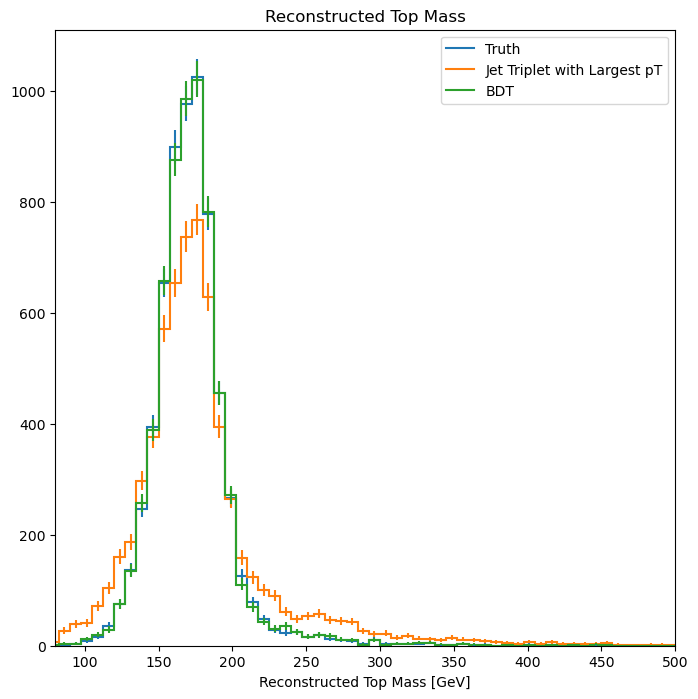

In [35]:
#### mass histogram ####

# binning
combinedmass_low = 0.0
combinedmass_high = 1500.0
combinedmass_numbins = 200

legendlist=["Truth","Jet Triplet with Largest pT","BDT"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(combinedmass_numbins, combinedmass_low, combinedmass_high, 
                      name="combinedmass", label="Reconstructed Top Mass [GeV]", flow=False),
    hist.axis.StrCategory(legendlist, name="truthlabel", label="Truth Label", growth=True),
)

# fill histogram
h.fill(combinedmass = all_correct_top_mass_even, truthlabel="Truth")
h.fill(combinedmass = all_correct_top_mass_odd, truthlabel="Truth")
h.fill(combinedmass = observable_list, truthlabel="Jet Triplet with Largest pT")

# fill in odd predictions
predictions = best_model_even.predict_proba(features_odd)[:,0]
predictions = predictions.reshape((int(len(predictions)/12),12))
which_combination = np.argmin(predictions,axis=-1)
    
top_mass_odd = np.zeros(features_odd_reshaped.shape[0])
for j in range(len(top_mass_odd)):
    top_mass_odd[j] = top_mass_candidates_odd[j,which_combination[j]]
        
h.fill(combinedmass = top_mass_odd, truthlabel="BDT")

# fill in even predictions
predictions = best_model_odd.predict_proba(features_even)[:,0]
predictions = predictions.reshape((int(len(predictions)/12),12))
which_combination = np.argmin(predictions,axis=-1)
    
top_mass_even = np.zeros(features_even_reshaped.shape[0])
for j in range(len(top_mass_even)):
    top_mass_even[j] = top_mass_candidates_even[j,which_combination[j]]
        
h.fill(combinedmass = top_mass_even, truthlabel="BDT")

fig,ax = plt.subplots(1,1,figsize=(8,8))
h.plot(ax=ax)
ax.legend(legendlist)
ax.set_title("Reconstructed Top Mass")
ax.set_xlim([80,500])
fig.show()

We can see from the above histograms that the BDT distribution is closer to the truth distribution than the non-ML reconstruction method, as expected from the performance metrics.